In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, recall_score, f1_score, roc_curve, auc

import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [3]:
# feature_selection_offset_0 = pd.read_csv(f"mimiciv_feature_selection_offset_0.csv")
# feature_selection_offset_1 = pd.read_csv(f"mimiciv_feature_selection_offset_1.csv")
# feature_selection_offset_2 = pd.read_csv(f"mimiciv_feature_selection_offset_2.csv")
feature_selection_offset_3 = pd.read_csv(f"mimiciv_feature_selection_offset_3.csv")
feature_selection_no_sepsis = pd.read_csv(f"mimiciv_feature_selection_no_sepsis.csv")

In [5]:
time_offset = 3

sepsis_df = feature_selection_offset_3

df = pd.concat([sepsis_df, feature_selection_no_sepsis])

In [4]:
sepsis_df

,sepsis,Systolic pressure Average hour 1,Systolic pressure Max hour 1,Pulse pressure Min hour 1,Pulse pressure Average hour 1,Pulse pressure Max hour 1,Heart rate Min hour 1,Heart rate Average hour 1,Heart rate Max hour 1,Temperature Average hour 1,...,Respiration rate Min hour 5,Respiration rate Average hour 5,Respiration rate Max hour 5,WBC count Min hour 5,WBC count Average hour 5,WBC count Max hour 5,pH Min hour 5,pH Average hour 5,Blood oxygen saturation Average hour 5,Blood oxygen saturation Max hour 5
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.9,6.9,6.9,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,23.0,23.0,NaN,NaN,NaN,NaN,NaN,99.0,99.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,98.0,98.0
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7588,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7589,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7590,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.49,7.49,NaN,NaN
7591,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.37,7.37,NaN,NaN


### Separação dos dados

In [7]:
positive_cases = df[df['sepsis'] == 1]
negative_cases = df[df['sepsis'] == 0]

test_samples = int(len(sepsis_df) * 0.25)
positive_test = positive_cases.sample(n=test_samples, random_state=1)
negative_test = negative_cases.sample(n=test_samples, random_state=1)

positive_train = positive_cases.drop(positive_test.index)
negative_train = negative_cases.drop(negative_test.index).sample(n=(int(len(sepsis_df) * 0.8)), random_state=42)

df_train = pd.concat([positive_train, negative_train]).sample(frac=1, random_state=42)
df_test = pd.concat([positive_test, negative_test]).sample(frac=1, random_state=42)

### Preencher dados nulos

In [9]:
features = [
    'Systolic pressure Average', 'Systolic pressure Max',
    'Pulse pressure Min', 'Pulse pressure Average', 'Pulse pressure Max',
    'Heart rate Min', 'Heart rate Average', 'Heart rate Max',
    'Temperature Average', 'Temperature Max',
    'Respiration rate Min', 'Respiration rate Average', 'Respiration rate Max',
    'WBC count Min', 'WBC count Average', 'WBC count Max',
    'pH Min', 'pH Average',
    'Blood oxygen saturation Average', 'Blood oxygen saturation Max'
]

for feature in features:
    related_columns = [f"{feature} hour {i}" for i in range(1, 6)]
    
    for i in range(1, 5):
        for col in related_columns:
            df_train[col] = df_train[related_columns].bfill(axis=1).ffill(axis=1)[col]
            df_test[col] = df_test[related_columns].bfill(axis=1).ffill(axis=1)[col]

    for col in related_columns:
        mean_value = df[col].mean()
        df_train[col].fillna(mean_value, inplace=True)
        df_test[col] = df_test[col].fillna(mean_value)

### Arquitetura do trabalho

    - In this research, we used a LSTM architecture with one hidden LSTM layer with 64 one cell memory blocks. The Adam optimization method [41] was used to train the LSTM networks.

In [11]:
X_train = df_train.drop(columns=['sepsis']).values
y_train = df_train['sepsis'].values
X_test = df_test.drop(columns=['sepsis']).values
y_test = df_test['sepsis'].values

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
class SepsisNet(nn.Module):
    def __init__(self, input_size=100, hidden_size=64, output_size=2, num_layers=1):
        super(SepsisNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

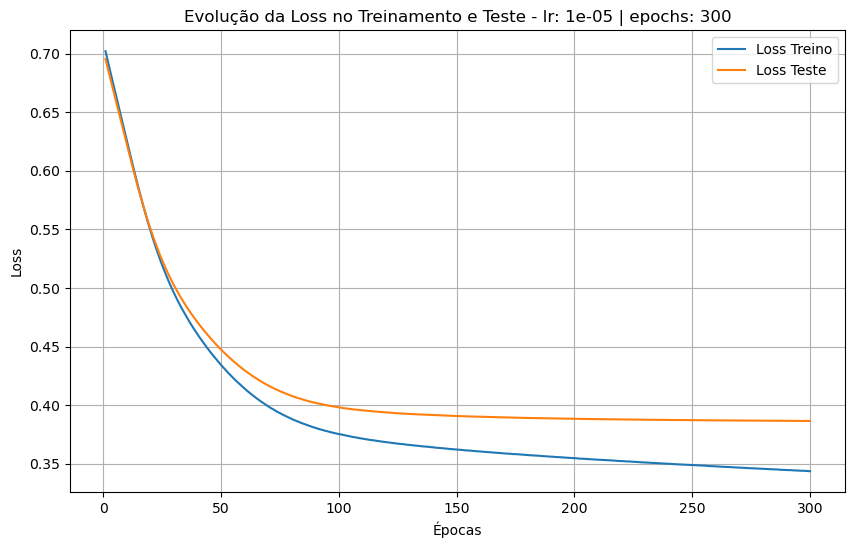

In [17]:
model = SepsisNet()
criterion = nn.CrossEntropyLoss()
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
test_losses = []

num_epochs = 300
patience = 500  
best_loss = float('inf')
stagnant_epochs = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
            outputs = model(inputs.unsqueeze(1)) 
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        stagnant_epochs = 0
    else:
        stagnant_epochs += 1

    if stagnant_epochs >= patience:
        print(f"Parando o treinamento na época {epoch+1} devido à ausência de melhora no test loss por {patience} épocas.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Loss Treino')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Loss Teste')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title(f'Evolução da Loss no Treinamento e Teste - lr: {lr} | epochs: {len(train_losses)}')
plt.legend()
plt.grid()
plt.show()

In [19]:
model.eval()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_scores.extend(outputs[:, 1].numpy())

accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

auroc = roc_auc_score(y_true, y_scores)

conf_matrix = confusion_matrix(y_true, y_pred)

classification_report_str = classification_report(y_true, y_pred, target_names=['Classe 0', 'Classe 1'], digits=4)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

results_df = pd.DataFrame({
        'y_true': y_true,
        'y_scores': y_scores
    })
#results_df.to_csv("../resultados/kam_reproducao_padronizado_24h.csv")

print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(classification_report_str)
print(f"Sensibilidade (Recall): {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"Precisão: {precision:.4f}")

Acurácia no conjunto de teste: 0.8248
AUROC: 0.8855
Matriz de Confusão:
[[1770  128]
 [ 537 1361]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0     0.7672    0.9326    0.8419      1898
    Classe 1     0.9140    0.7171    0.8037      1898

    accuracy                         0.8248      3796
   macro avg     0.8406    0.8248    0.8228      3796
weighted avg     0.8406    0.8248    0.8228      3796

Sensibilidade (Recall): 0.7171
Especificidade: 0.9326
Precisão: 0.9140


### Resultados do trabalho

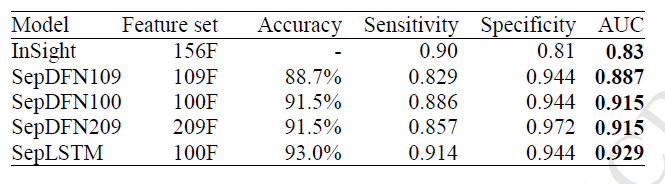

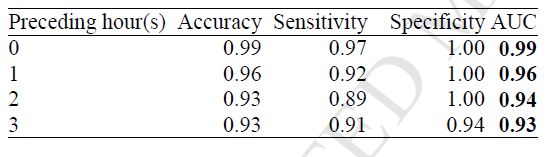

# Conformal Prediction

In [18]:
def InverseProbabilityNC(predicted_score, y):
    prob = np.zeros(y.size, dtype=np.float32)
    for i, y_ in enumerate(y):
        if y_ >= predicted_score.shape[1]:
            prob[i] = 0
        else:
            prob[i] = predicted_score[i, int(y_)]
    return 1 - prob


def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    for test_point_conformity_score in non_conformity_scores_test:
        p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (
            len(non_conformity_scores_train) + 1)
        p_values.append(p_value)
    return np.array(p_values)

In [19]:
def prediction_sets(X_train, y_train, X_test, y_test, significance_level=0.05, num_epochs=220, lr = 0.00001, batch_size=64):
    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []
    
    for i in range(len(y_test)):
        print(f"Processing sample {i+1}/{len(y_test)}")
        
        X_train_plus_test = np.vstack([X_train, X_test[i].reshape(1, -1)])
        y_train_plus_test_0 = np.append(y_train, 0)
        y_train_plus_test_1 = np.append(y_train, 1)
        
        model_0 = SepsisNet()
        optimizer_0 = optim.Adam(model_0.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        model_1 = SepsisNet()
        optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)
        
        X_tensor_0 = torch.tensor(X_train_plus_test, dtype=torch.float32).unsqueeze(1)
        y_tensor_0 = torch.tensor(y_train_plus_test_0, dtype=torch.long)
        dataset_0 = TensorDataset(X_tensor_0, y_tensor_0)
        dataloader_0 = DataLoader(dataset_0, batch_size=batch_size, shuffle=True)
        
        X_tensor_1 = torch.tensor(X_train_plus_test, dtype=torch.float32).unsqueeze(1)
        y_tensor_1 = torch.tensor(y_train_plus_test_1, dtype=torch.long)
        dataset_1 = TensorDataset(X_tensor_1, y_tensor_1)
        dataloader_1 = DataLoader(dataset_1, batch_size=batch_size, shuffle=True)
        
        for epoch in range(num_epochs):
            model_0.train()
            for batch_X, batch_y in dataloader_0:
                optimizer_0.zero_grad()
                outputs_0 = model_0(batch_X)
                loss_0 = criterion(outputs_0, batch_y)
                loss_0.backward()
                optimizer_0.step()
            
            model_1.train()
            for batch_X, batch_y in dataloader_1:
                optimizer_1.zero_grad()
                outputs_1 = model_1(batch_X)
                loss_1 = criterion(outputs_1, batch_y)
                loss_1.backward()
                optimizer_1.step()
        
        model_0.eval()
        model_1.eval()
        
        with torch.no_grad():
            y_pred_train_0 = torch.softmax(model_0(X_tensor_0), dim=1).numpy()
            y_pred_train_1 = torch.softmax(model_1(X_tensor_1), dim=1).numpy()

        del model_0
        del model_1
        
        non_conformity_scores_train_0 = InverseProbabilityNC(y_pred_train_0[:-1], y_train_plus_test_0[:-1])
        non_conformity_scores_train_1 = InverseProbabilityNC(y_pred_train_1[:-1], y_train_plus_test_1[:-1])
        
        non_conformity_scores_test_0 = InverseProbabilityNC(y_pred_train_0[-1].reshape(1, -1), np.array([0]))
        non_conformity_scores_test_1 = InverseProbabilityNC(y_pred_train_1[-1].reshape(1, -1), np.array([1]))
        
        p_value_class_0 = compute_p_value(non_conformity_scores_train_0, non_conformity_scores_test_0)
        p_value_class_1 = compute_p_value(non_conformity_scores_train_1, non_conformity_scores_test_1)
        
        p_values_class_0.append(p_value_class_0)
        p_values_class_1.append(p_value_class_1)

        print(f"Sample {i}:    class_0: {p_value_class_0}      class_1: {p_value_class_1}")
        
        if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([True, True])
        elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
            prediction_sets.append([True, False])
        elif (p_value_class_0 <= significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([False, True])
        else:
            prediction_sets.append([False, False])

    with open(f'mimiciv_p_values_class_0_{time_offset}_hour_2000_2250.pkl', 'wb') as f:
        pickle.dump(p_values_class_0, f)
    with open(f'mimiciv_p_values_class_1_{time_offset}_hour_2000_2250.pkl', 'wb') as f:
        pickle.dump(p_values_class_1, f)
    
    return prediction_sets, p_values_class_0, p_values_class_1

In [21]:
prediction_sets(X_train, y_train, X_test[2000:2250], y_test[2000:2250])

Processing sample 1/250



KeyboardInterrupt



In [20]:
from joblib import Parallel, delayed
from tqdm import tqdm

significance_level = 0.05
num_epochs = 250
lr = 0.00001
batch_size = 64

# Subconjunto de teste
X_test_ = X_test[2250:3000]
y_test_ = y_test[2250:3000]

# Função principal de processamento individual
def process_sample(i):
    print(f"Processing sample {i + 1}/{len(y_test_)}")
    
    X_sample = X_test_[i].reshape(1, -1)

    # Construção do conjunto com a amostra rotulada com 0 e com 1
    X_train_plus_test = np.vstack([X_train, X_sample])
    y_train_plus_test_0 = np.append(y_train, 0)
    y_train_plus_test_1 = np.append(y_train, 1)

    # Modelo e otimizador para label 0
    model_0 = SepsisNet()
    optimizer_0 = optim.Adam(model_0.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Modelo e otimizador para label 1
    model_1 = SepsisNet()
    optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)

    # TensorDatasets
    X_tensor = torch.tensor(X_train_plus_test, dtype=torch.float32).unsqueeze(1)
    y_tensor_0 = torch.tensor(y_train_plus_test_0, dtype=torch.long)
    y_tensor_1 = torch.tensor(y_train_plus_test_1, dtype=torch.long)

    dataloader_0 = DataLoader(TensorDataset(X_tensor, y_tensor_0), batch_size=batch_size, shuffle=True)
    dataloader_1 = DataLoader(TensorDataset(X_tensor, y_tensor_1), batch_size=batch_size, shuffle=True)

    # Treinamento
    for epoch in range(num_epochs):
        model_0.train()
        for batch_X, batch_y in dataloader_0:
            optimizer_0.zero_grad()
            outputs = model_0(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer_0.step()

        model_1.train()
        for batch_X, batch_y in dataloader_1:
            optimizer_1.zero_grad()
            outputs = model_1(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer_1.step()

    model_0.eval()
    model_1.eval()

    with torch.no_grad():
        y_pred_0 = torch.softmax(model_0(X_tensor), dim=1).numpy()
        y_pred_1 = torch.softmax(model_1(X_tensor), dim=1).numpy()

    del model_0
    del model_1

    # Nonconformity scores
    nc_train_0 = InverseProbabilityNC(y_pred_0[:-1], y_train_plus_test_0[:-1])
    nc_train_1 = InverseProbabilityNC(y_pred_1[:-1], y_train_plus_test_1[:-1])

    nc_test_0 = InverseProbabilityNC(y_pred_0[-1].reshape(1, -1), np.array([0]))
    nc_test_1 = InverseProbabilityNC(y_pred_1[-1].reshape(1, -1), np.array([1]))

    # P-values
    p_0 = compute_p_value(nc_train_0, nc_test_0)
    p_1 = compute_p_value(nc_train_1, nc_test_1)

    # Prediction set
    if (p_0 > significance_level) and (p_1 > significance_level):
        prediction_set = [True, True]
    elif (p_0 > significance_level):
        prediction_set = [True, False]
    elif (p_1 > significance_level):
        prediction_set = [False, True]
    else:
        prediction_set = [False, False]

    return p_0, p_1, prediction_set

# Processar em paralelo
results = Parallel(n_jobs=4)(delayed(process_sample)(i) for i in tqdm(range(len(y_test_))))

# Desempacotar resultados
p_values_class_0, p_values_class_1, prediction_sets = zip(*results)

# Salvar resultados
with open(f'mimiciv_p_values_class_0_{time_offset}_hour_2250_3000.pkl', 'wb') as f:
    pickle.dump(p_values_class_0, f)
with open(f'mimiciv_p_values_class_1_{time_offset}_hour_2250_3000.pkl', 'wb') as f:
    pickle.dump(p_values_class_1, f)

100%|██████████| 750/750 [30:58:59<00:00, 148.72s/it]   


In [13]:
with open(f'mimiciv_p_values_class_0_{time_offset}_hour.pkl', 'rb') as f:
    p_values_test_set_class_0 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour.pkl', 'rb') as f:
    p_values_test_set_class_1 = pickle.load(f)


with open(f'mimiciv_p_values_class_0_{time_offset}_hour_200_500.pkl', 'rb') as f:
    p_values_test_set_class_0_2 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_200_500.pkl', 'rb') as f:
    p_values_test_set_class_1_2 = pickle.load(f)

with open(f'mimiciv_p_values_class_0_{time_offset}_hour_500_800.pkl', 'rb') as f:
    p_values_test_set_class_0_3 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_500_800.pkl', 'rb') as f:
    p_values_test_set_class_1_3 = pickle.load(f)

with open(f'mimiciv_p_values_class_0_{time_offset}_hour_800_1200.pkl', 'rb') as f:
    p_values_test_set_class_0_4 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_800_1200.pkl', 'rb') as f:
    p_values_test_set_class_1_4 = pickle.load(f)

with open(f'mimiciv_p_values_class_0_{time_offset}_hour_1200_1500.pkl', 'rb') as f:
    p_values_test_set_class_0_5 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_1200_1500.pkl', 'rb') as f:
    p_values_test_set_class_1_5 = pickle.load(f)

with open(f'mimiciv_p_values_class_0_{time_offset}_hour_1500_2000.pkl', 'rb') as f:
    p_values_test_set_class_0_6 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_1500_2000.pkl', 'rb') as f:
    p_values_test_set_class_1_6 = pickle.load(f)

with open(f'mimiciv_p_values_class_0_{time_offset}_hour_2000_2250.pkl', 'rb') as f:
    p_values_test_set_class_0_7 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_2000_2250.pkl', 'rb') as f:
    p_values_test_set_class_1_7 = pickle.load(f)

with open(f'mimiciv_p_values_class_0_{time_offset}_hour_2250_3000.pkl', 'rb') as f:
    p_values_test_set_class_0_8 = pickle.load(f)

with open(f'mimiciv_p_values_class_1_{time_offset}_hour_2250_3000.pkl', 'rb') as f:
    p_values_test_set_class_1_8 = pickle.load(f)
    
p_values_test_set_class_0 = np.concatenate([p_values_test_set_class_0, p_values_test_set_class_0_2, p_values_test_set_class_0_3, p_values_test_set_class_0_4, p_values_test_set_class_0_5, p_values_test_set_class_0_6, p_values_test_set_class_0_7, p_values_test_set_class_0_8])
p_values_test_set_class_1 = np.concatenate([p_values_test_set_class_1, p_values_test_set_class_1_2, p_values_test_set_class_1_3, p_values_test_set_class_1_4, p_values_test_set_class_1_5, p_values_test_set_class_1_6, p_values_test_set_class_1_7, p_values_test_set_class_1_8])

In [59]:
def conformal_prediction_metrics(p_values_class_0, p_values_class_1, y_test, significance_level):
    predictions_test_set = []

    for p0, p1 in zip(p_values_class_0, p_values_class_1):
        if (p0 > significance_level) and (p1 > significance_level):
            predictions_test_set.append(0 if p0 > p1 else 1)
        elif (p0 > significance_level) and (p1 <= significance_level):
            predictions_test_set.append(0)
        elif (p0 <= significance_level) and (p1 > significance_level):
            predictions_test_set.append(1)
        else:
            predictions_test_set.append(None)

    valid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is not None]
    invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

    # Corrigido: usar iloc para acessar os valores pela posição
    y_test_valid = [y_test[i] for i in valid_indices]
    y_pred_valid = [predictions_test_set[i] for i in valid_indices]

    accuracy = accuracy_score(y_test_valid, y_pred_valid)
    recall = recall_score(y_test_valid, y_pred_valid)
    f1 = f1_score(y_test_valid, y_pred_valid)
    y_score = [1 - p[0] for p in p_values_test_set_class_0]  # ou p_values_class_1

    # Filtrando os mesmos índices válidos
    y_score_valid = [y_score[i] for i in valid_indices]
    
    fpr, tpr, thresholds = roc_curve(y_test_valid, y_score_valid)
    auroc = auc(fpr, tpr)

    conf_matrix = confusion_matrix(y_test_valid, y_pred_valid)
    report = classification_report(y_test_valid, y_pred_valid, digits=4)

    results_df = pd.DataFrame({
        'y_true': [y_test[i] for i in valid_indices],
        'y_pred': [y_score[i] for i in valid_indices]
    })
    #results_df.to_csv('../resultados/kam_cp_original_005.csv')

    coverage_rate = len(valid_indices) / len(y_test)
    set_size = np.mean([
        int(p_values_class_0[i] > significance_level) + int(p_values_class_1[i] > significance_level)
        for i in range(len(y_test))
    ])

    y_test_np = y_test
    removed_sepsis = np.sum(y_test_np[invalid_indices] == 1)
    removed_no_sepsis = np.sum(y_test_np[invalid_indices] == 0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Coverage Rate: {coverage_rate:.4f}")
    print(f"Set Size (avg prediction set size): {set_size:.4f}")
    print(f"Removed samples (No sepsis): {removed_no_sepsis}")
    print(f"Removed samples (Sepsis): {removed_sepsis}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No sepsis', 'Sepsis'],
                yticklabels=['No sepsis', 'Sepsis'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'auroc': auroc,
        'coverage_rate': coverage_rate,
        'set_size': set_size,
        'removed_sepsis': removed_sepsis,
        'removed_no_sepsis': removed_no_sepsis,
        'results_df': results_df
    }

Accuracy: 0.8106
Recall: 0.6858
F1-score: 0.7838
AUROC: 0.8663
Coverage Rate: 0.9980
Set Size (avg prediction set size): 1.0567
Removed samples (No sepsis): 1
Removed samples (Sepsis): 5

Classification Report:
              precision    recall  f1-score   support

           0     0.7481    0.9358    0.8315      1495
           1     0.9146    0.6858    0.7838      1499

    accuracy                         0.8106      2994
   macro avg     0.8314    0.8108    0.8077      2994
weighted avg     0.8315    0.8106    0.8076      2994



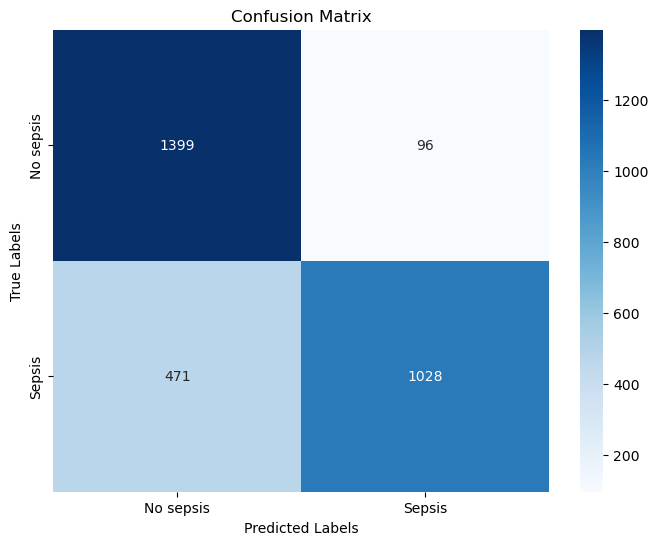

In [69]:
metrics = conformal_prediction_metrics(
    p_values_class_0=p_values_test_set_class_0,
    p_values_class_1=p_values_test_set_class_1,
    y_test=y_test[:len(p_values_test_set_class_0)],  # lista ou array com rótulos verdadeiros
    significance_level=0.15
)